<a href="https://colab.research.google.com/github/TJ-Solergibert/Agarrar-tabla-url/blob/main/ElBueno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Nos piden obtener, organizar y guardar los datos de los juzgados de varias provincias de España. Estos datos los encontramos en un apartado de la web del poder judicial. 

http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/Directorio-de-Organos-Judiciales/

---



Como se puede observar al entrar a cualquier provincia, nos aparecerá una tabla con los datos de los juzgados repartidos en varias páginas.

Por lo que para realizar la tarea tendremos que:

1.   Agarrar los datos de cada página y guardarlos en una tabla.
2.   Navegar a traves de las diferentes páginas.
3.   Juntar las tablas con los datos de la misma provincia.
3.   Navegar a traves de las diferentes provincias.
4.   Guardar los datos de cada provincia en una hoja de excel.



# Importar librerias

Primero importaremos las librerias que utilizaremos a lo largo del proyecto.



*   **pandas**
*   **request**
*   **OS**
*   **xlswriter**





In [1]:
!pip install xlsxwriter                                         # Instalamos la libreria xlswriter ya que no está de serie en Colab

     |████████████████████████████████| 153kB 5.5MB/s 


In [2]:
import pandas as pd
import requests
import os
import xlsxwriter

# Agarrar los datos a partir de una URL

Primero haremos una demostración de como obtenbdremos los datos a partir de una URL. 

In [3]:
url = "http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=08&startAt=440&pag01=45"

Nos interesa agarrar los datos de la tabla que aparece en la página web. 


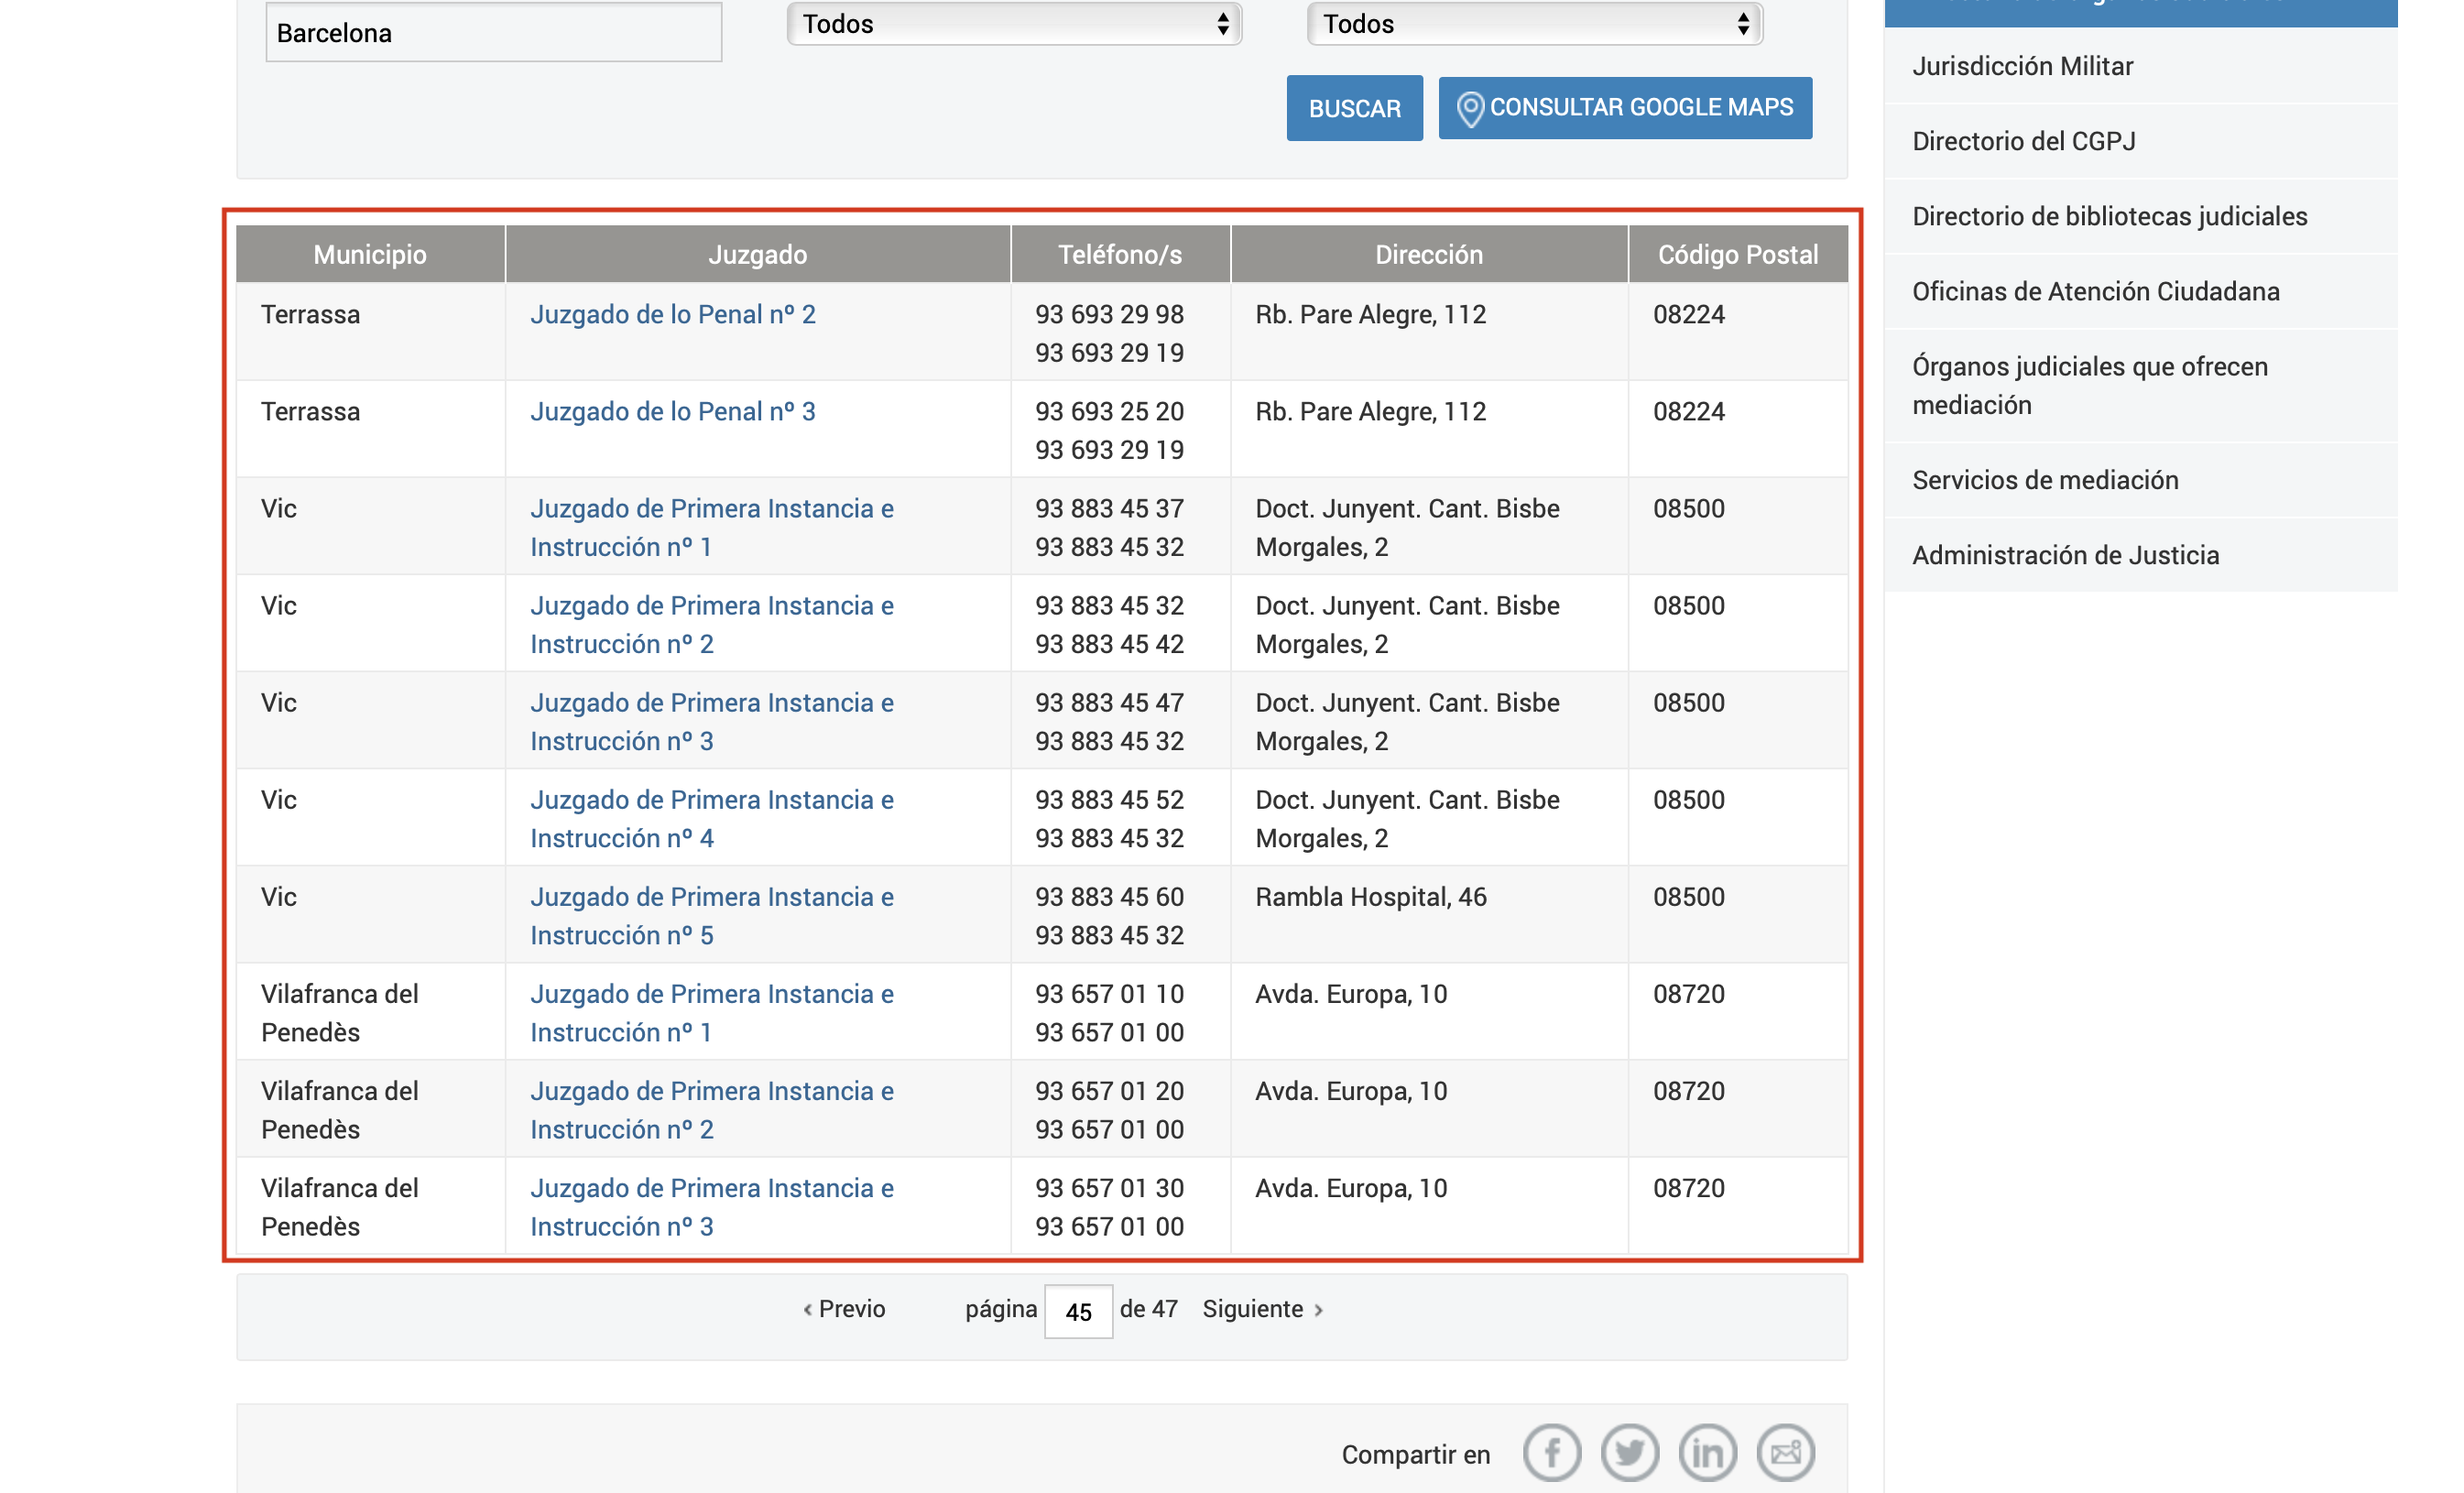

Para ello construiremos la función URLToDataFrame que nos devolverá un DataFrame con los datos de la URL que introduzcamos como argumento.

In [4]:
 def URLToDataFrame(url):                                                       
  html = requests.get(url).content                  # Haremos una petición a la URL y nos devolverá el contenido de la página
  df_list = pd.read_html(html)                      # Leemos el contenido de la página y obtenemos una lista con los datos
  df = df_list[-1]                                  # Transformamos la lista a un DataFrame
  
  return df                                                                

El resultado es el siguiente Dataframe:




In [5]:
prueba = URLToDataFrame(url)
prueba

,Municipio,Juzgado,Teléfono/s,Dirección,Código Postal
0,Terrassa,Juzgado de lo Penal nº 2,93 693 29 9893 693 29 19,"Rb. Pare Alegre, 112",8224
1,Terrassa,Juzgado de lo Penal nº 3,93 693 25 2093 693 29 19,"Rb. Pare Alegre, 112",8224
2,Vic,Juzgado de Primera Instancia e Instrucción nº 1,93 883 45 3793 883 45 32,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
3,Vic,Juzgado de Primera Instancia e Instrucción nº 2,93 883 45 3293 883 45 42,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
4,Vic,Juzgado de Primera Instancia e Instrucción nº 3,93 883 45 4793 883 45 32,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
5,Vic,Juzgado de Primera Instancia e Instrucción nº 4,93 883 45 5293 883 45 32,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
6,Vic,Juzgado de Primera Instancia e Instrucción nº 5,93 883 45 6093 883 45 32,"Rambla Hospital, 46",8500
7,Vilafranca del Penedès,Juzgado de Primera Instancia e Instrucción nº 1,93 657 01 1093 657 01 00,"Avda. Europa, 10",8720
8,Vilafranca del Penedès,Juzgado de Primera Instancia e Instrucción nº 2,93 657 01 2093 657 01 00,"Avda. Europa, 10",8720
9,Vilafranca del Penedès,Juzgado de Primera Instancia e Instrucción nº 3,93 657 01 3093 657 01 00,"Avda. Europa, 10",8720


## Dividir los números de teléfono

Como hemos podido observar, los juzgados disponen de 2 números de telefono. Es por ello que los dividiremos introduciendo el carácter "/" entre los dos números de teléfono.

In [6]:
prueba["Teléfono/s"].head()

0    93 693 29 9893 693 29 19
1    93 693 25 2093 693 29 19
2    93 883 45 3793 883 45 32
3    93 883 45 3293 883 45 42
4    93 883 45 4793 883 45 32
Name: Teléfono/s, dtype: object

In [7]:
def SplitPhones(df):                                       
  df["Teléfono/s"] = df["Teléfono/s"].str[:12] + " / " + df["Teléfono/s"].str[12:]
  
  return df

In [8]:
prueba = SplitPhones(prueba)
prueba.head()

,Municipio,Juzgado,Teléfono/s,Dirección,Código Postal
0,Terrassa,Juzgado de lo Penal nº 2,93 693 29 98 / 93 693 29 19,"Rb. Pare Alegre, 112",8224
1,Terrassa,Juzgado de lo Penal nº 3,93 693 25 20 / 93 693 29 19,"Rb. Pare Alegre, 112",8224
2,Vic,Juzgado de Primera Instancia e Instrucción nº 1,93 883 45 37 / 93 883 45 32,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
3,Vic,Juzgado de Primera Instancia e Instrucción nº 2,93 883 45 32 / 93 883 45 42,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500
4,Vic,Juzgado de Primera Instancia e Instrucción nº 3,93 883 45 47 / 93 883 45 32,"Doct. Junyent. Cant. Bisbe Morgales, 2",8500


# Navegar a través de las diferentes páginas

Si nos fijamos en diferentes paginas de la misma provincia, podremos observar que las URLs siguen un patrón.

Página 2 Barcelona: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=08&startAt=10&pag01=2



Página 3 Barcelona: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=08&startAt=20&pag01=3

Página 4 Barcelona: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=08&startAt=30&pag01=4

Como podemos observar en las diferentes URLs, en función de la página en la que nos encontremos el parametro "*startAt=*" es  **(Número de página actual-1)*10** y "*pag01=*" es el **Número de página actual**.

# Navegar a través de las diferentes comunidades

Análogamente tambien podemos observar que existe un número de provincia para cada provincia y este viene implicito en la URL en el parámetro "*provincia=*".

Página 2 Sevilla: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=41&startAt=10&pag01=2

Página 2 Málaga: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=29&startAt=10&pag01=2

Página 2 Zaragoza: http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=50&startAt=10&pag01=2

# El diccionario

Para poder navegar por las diferentes paginas y provincias, crearemos un diccionario que tendrá como clave el nombre de la provincia y como datos el Número identificativo de provincia y el Número de páginas. 

In [9]:
Dict = {
  "Sevilla": [41, 16],
  "Málaga": [29, 15],
  "Zaragoza": [50, 9],
  "Barcelona": ["08", 47],
  "Córdoba": [14, 7],
  "Badajoz": ["06", 6],
  "Tenerife": [38, 10],
  "Burgos": ["09", 5],
  "Valencia": [46, 23],
  "La Rioja": [26, 4],
}

In [10]:
Dict["Tenerife"][0]                           # El output será el codigo de provincia de Tenerife

38

# Código final

In [11]:
path_to_cwd= os.getcwd()                         # Para obtener el directorio en el que nos encontramos
path = os.path.join(path_to_cwd, 'Output.xlsx')  # Para obtener el directorio donde guardaremos el archivo con el Output

In [12]:
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')  # writer será el "ayudante" que nos escribirá los DataFrames con los datos en las hojas del excel

for provincia in Dict.keys():                    # Por cada provincia del diccionario
  i = 1;                                         # Creamos la variable i que contiene el número de página actual
  df = pd.DataFrame(columns=prueba.columns)      # Creamos un DataFrame para esta provincia estableciendo ya el nombre de las columnas
  while i <=Dict[provincia][1]:                  # Mientras no lleguemos a la última hoja
                                                 # Construimos la URL teniendo en cuenta los patrones que hemos observado anteriormente
    url = "http://www.poderjudicial.es/cgpj/es/Servicios/Directorio/ch.Directorio-de-Organos-Judiciales.formato3/?provincia=" + str(Dict[provincia][0]) + "&startAt=" + str((i-1)*10) + "&pag01=" + str(i) 
    df_a = URLToDataFrame(url)                   # Usamos la funcion URLToDataframe que nos devuelve un Dataframe con los datos de la URL pasada como argumento
    df = df.append(df_a, ignore_index=True)      # Cada página la añadimos al Dataframe de la provincia
    i+=1                                         # Incrementamos el número de página
  df.index += 1                                  # Cambiamos el index del Dataframe que contiene los datos de toda la provincia de 0 a 1 
  df = SplitPhones(df)                           # Usamos la función SplitPhones para separar los numeros de telefono de todos los juzgados de la provincia
  df.to_excel(writer, sheet_name = provincia)    # Escribímos los datos del Datframe que contiene todos los datos de la provincia en una nueva hoja de excel que tiene como nombre el nombre de la provincia

writer.save()                                    # Guardamos el archivo

## Posibles upgrades

Como todo en la vida, siempre se puede mejorar. He encontrado varios detalles que se podrían pulir.


*   No escribe el 0 en los códigos postales que empiezan por 0. En Barcelona por ejemplo, el 08075 lo escribe como 8075.
*   Dividir en dos celdas los números de teléfono. Como hemos podido observar, la mayoría de juzgados poseen dos numeros de telefonos y hemos decidido conservarlos en la misma celda separandolos con una barra "/". Tal vez sería mejor separarlos en dos celdas diferentes.

